## Example 1: Neurodegeneration-Associated Genes in Humans

We aggregated public data across AD, PD, ALS, and HD, identifying 139 overlapping genes. Using BioComet and the Leiden algorithm, we detected gene communities, leading to refined functional insights and highlighting potential inflammatory or metabolic pathways involved in neurodegeneration.

This notebook aims to showcase BioComet's capability to navigate complex biological datasets, offering insights into disease mechanisms and potential therapeutic targets.

In [1]:
import biocomet as bc
from biocomet import examples

# load 139 common genes
common_genes = examples.hs_ndd_genes

common_genes

0         COL4A1
1           CLK1
2           SMTN
3           PKD1
4      RAB11FIP4
         ...    
134         TNXB
135        RPL35
136         NT5E
137         USP4
138        MMRN2
Length: 139, dtype: object

Saving interaction network to ./PPI_networks/full_network.png


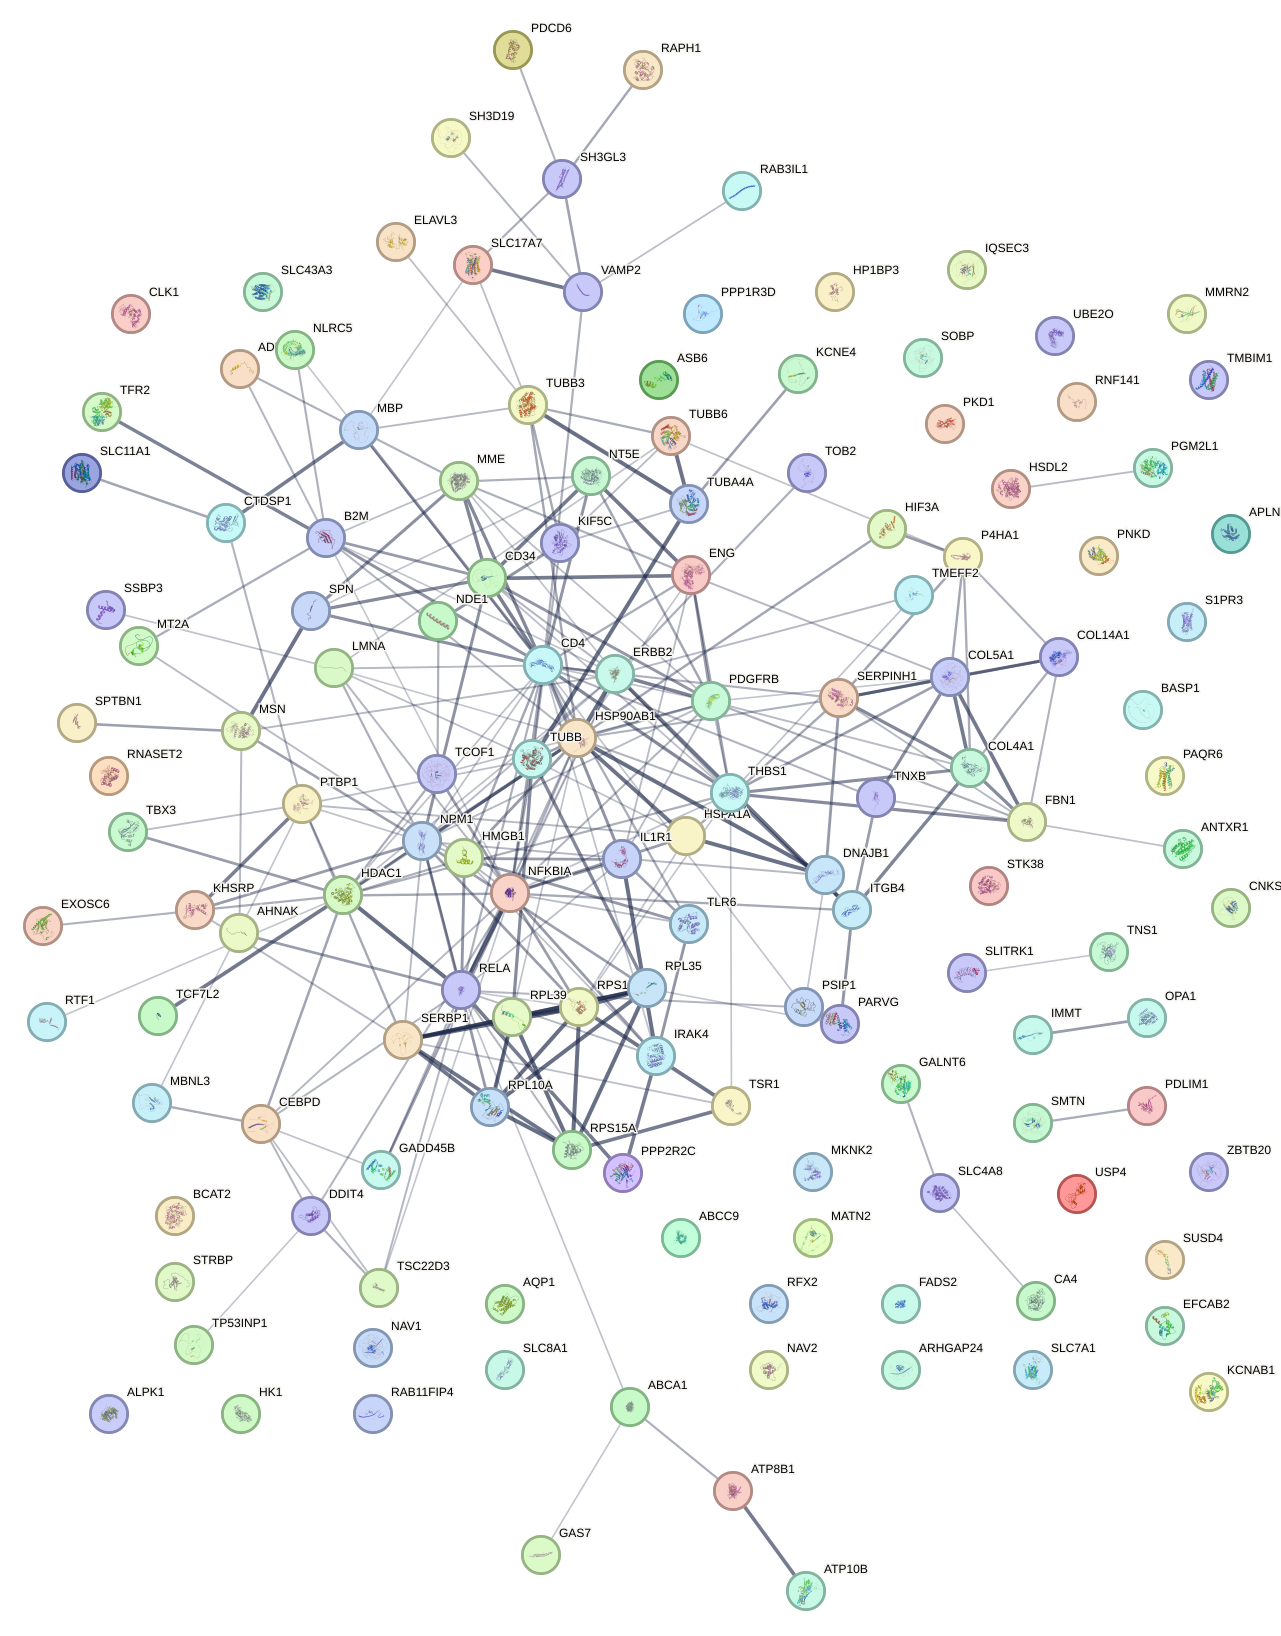

In [2]:
# build the PPI object with the default min score of 400 for a connection and the exclusion of solely text-based associations
PPI = bc.PPIGraph(gene_list=common_genes, organism='human', min_score=400)

# display the full PPI Graph
PPI.plot_PPI(full_network=True)


#### Whole network analysis

Saving PPI word clouds to ./WordCloudPPI_networks/community Full Network's_ppi_wordcloud.png


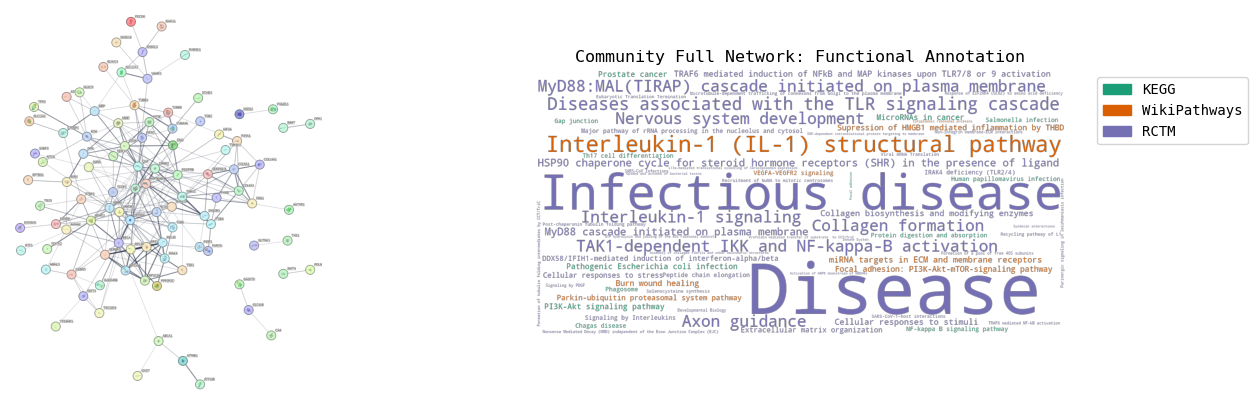

{'Full Network':          category          term  number_of_genes  \
 0    COMPARTMENTS  GOCC:0005615               25   
 1    COMPARTMENTS  GOCC:0043226              102   
 2    COMPARTMENTS  GOCC:0043229               99   
 3    COMPARTMENTS  GOCC:0065010               16   
 4    COMPARTMENTS  GOCC:0070062               15   
 ..            ...           ...              ...   
 474           HPO    HP:0001895                4   
 475           HPO    HP:0002621                5   
 476           HPO    HP:0011024               23   
 477           HPO    HP:0011915                4   
 478           HPO    HP:0025031               33   
 
      number_of_genes_in_background  ncbiTaxonId  \
 0                             1027         9606   
 1                            10113         9606   
 2                             9609         9606   
 3                              473         9606   
 4                              428         9606   
 ..                             ..

In [3]:
# calculate the functional annotation
PPI.get_functional_annotation(full_network=True, categories='pathways')

# display the results with the network
PPI.plot_Wordclouds_PPI(full_network=True, categories='pathways')

# extract and display the results as a dataframe
full_network_results = PPI.func_annotation_full_network
full_network_results

#### Community Detection and community analysis

The best modularity based on the networkx is 0.4811272938686066
For reproducing exactly this community detection, run PPIGraph.community_detection(algorithm='leiden', seed=2466)
The modularity based on this seed is 0.4811272938686066
Saving PPI word clouds to ./WordCloudPPI_networks/community 0's_ppi_wordcloud.png


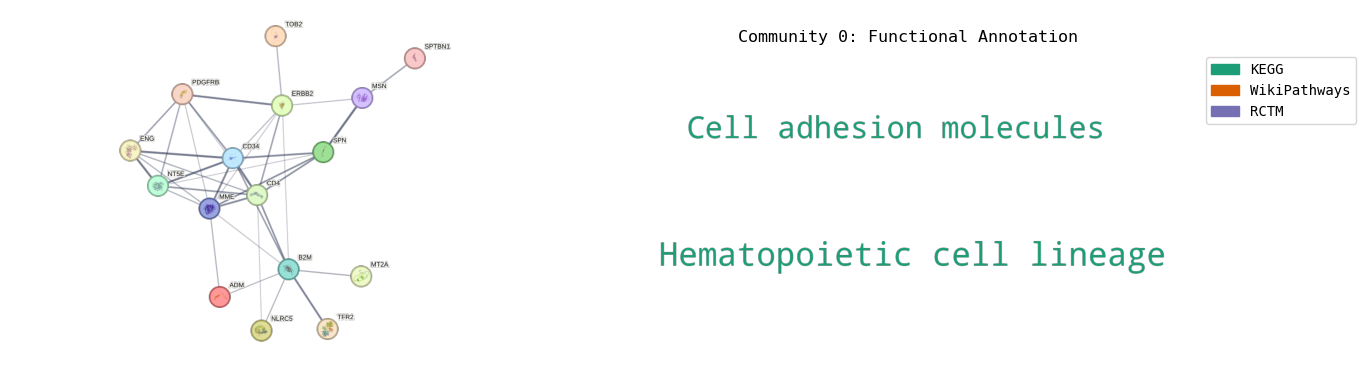

Saving PPI word clouds to ./WordCloudPPI_networks/community 1's_ppi_wordcloud.png


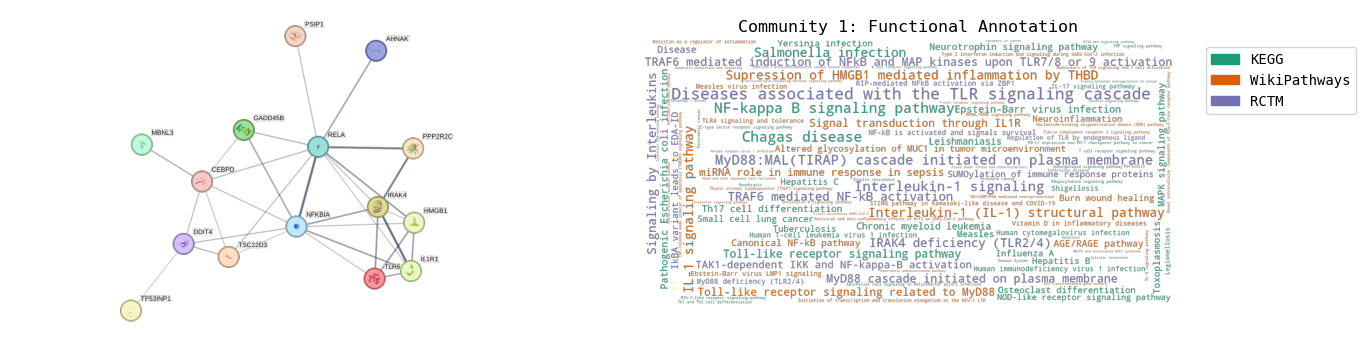

Saving PPI word clouds to ./WordCloudPPI_networks/community 2's_ppi_wordcloud.png


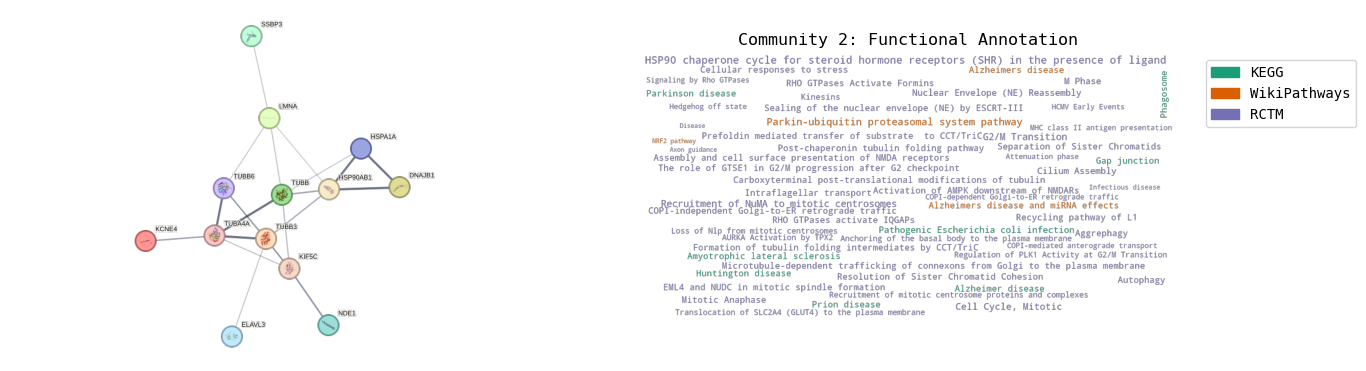

Saving PPI word clouds to ./WordCloudPPI_networks/community 3's_ppi_wordcloud.png


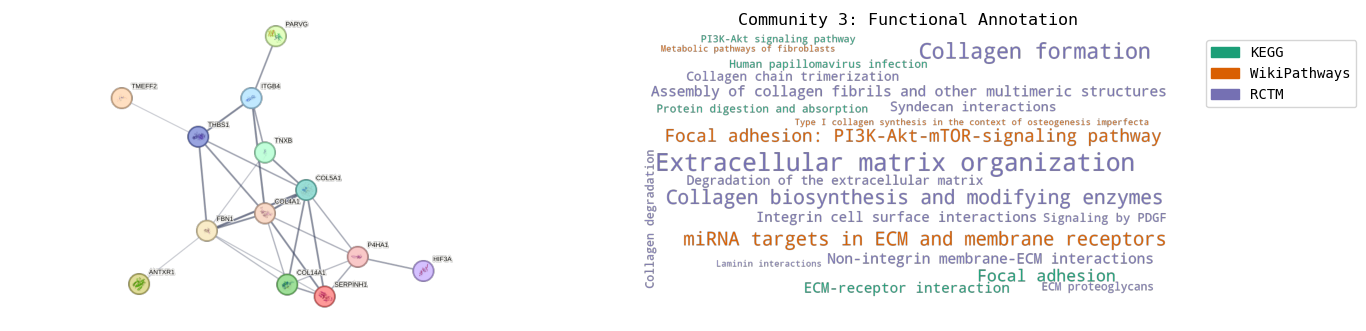

Saving PPI word clouds to ./WordCloudPPI_networks/community 5's_ppi_wordcloud.png


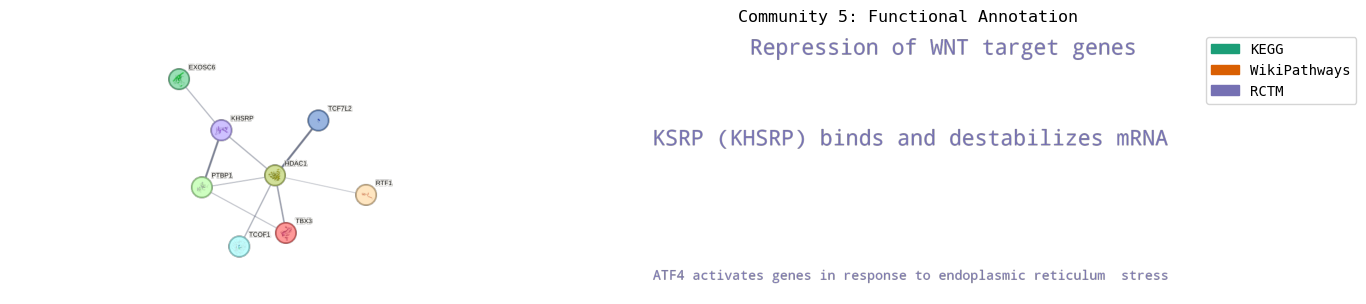

Saving PPI word clouds to ./WordCloudPPI_networks/community 6's_ppi_wordcloud.png


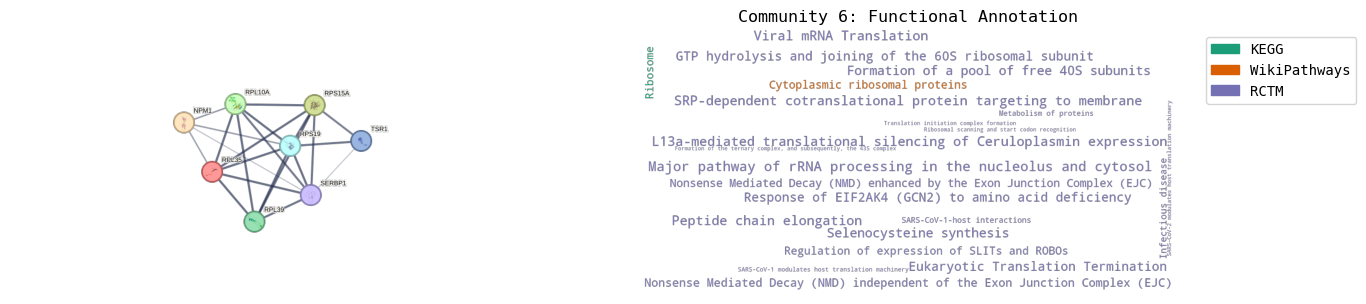

In [4]:
# identify communities using the leiden algorithm
PPI.community_detection(algorithm='leiden', iterations=100)

# both, the leiden and louvain algorithm are non-deterministic. This means, that when run multiple times, so exact results might vary.
# therefore, we implemented the community detection in a way, so that it prints out the static seed for the best found partition in this trial
# so to reproduce the results, the algorithm can be run with this particular seed

# feel free to change the seed here, however, the following content is adapted to the seed 5944
PPI.community_detection(algorithm='leiden', seed=5944)

# calculate the functional annotation
PPI.get_functional_annotation(full_network=False, categories='pathways')

# display the results with the network
PPI.plot_Wordclouds_PPI(full_network=False, categories='pathways')

# extract and display the results as a dataframe
community_results = PPI.func_annotation

# in case you want to look at the functional enrichment tables:
# community_results 

In [5]:
# based on the results with seed 5944, we can label the community e.g. like that:

community_labels = {
    0: "Hematopoiesis & Cell Adhesion",              #Combines the themes of hematopoietic lineage development and cell adhesion processes.
    1: "Immune Response & Signaling",                #Captures the broad theme of immune response mechanisms, including TLR signaling and NF-kappa B pathways.
    2: "Cell Cycle & Mitotic Regulation",            #Reflects the focus on cell cycle processes, mitotic events, and related regulatory mechanisms.
    3: "Extracellular Matrix & Collagen Synthesis",  #Highlights the emphasis on extracellular matrix organization and collagen-related processes.
    5: "mRNA Stability & Stress Response",           #Represents the processes related to mRNA stability and cellular responses to stress, including WNT signaling repression.
    6: "rRNA Processing & Protein Targeting",        #Encompasses themes of ribosomal RNA processing and mechanisms of protein targeting, reflecting a focus on fundamental cellular processes.
}



Now we can inspect those genes contributing to the Disease pathway in of the Reactome database and see which communities those genes contribute to 

In [6]:
# we can derive the table from the funcitional enrichment results on the whole graph 
full_network_results_df = full_network_results['Full Network']

# from here, we can check, which genes actually contributed to the most significant pathway found: the reactome pathway 'Disease'
disease_genes = full_network_results_df[(full_network_results_df['description'] == 'Disease') & (full_network_results_df['category'] == 'RCTM')]['preferredNames']

# add attribute to nodes whether they are implciated in the Reactome Pathway 'Disease'
for n in PPI.network.nodes:
    # Assign the 'Disease' attribute to each node
    if n in disease_genes.values[0]:
        PPI.network.nodes[n]["Disease"] = 1
    else:
        PPI.network.nodes[n]["Disease"] = 0


As the Term 'Disease' is quite unspecific, let's try to trace, if we find those genes contributing to this term as being spread out in different communities that are more descriptive of their underlying functinoal association 

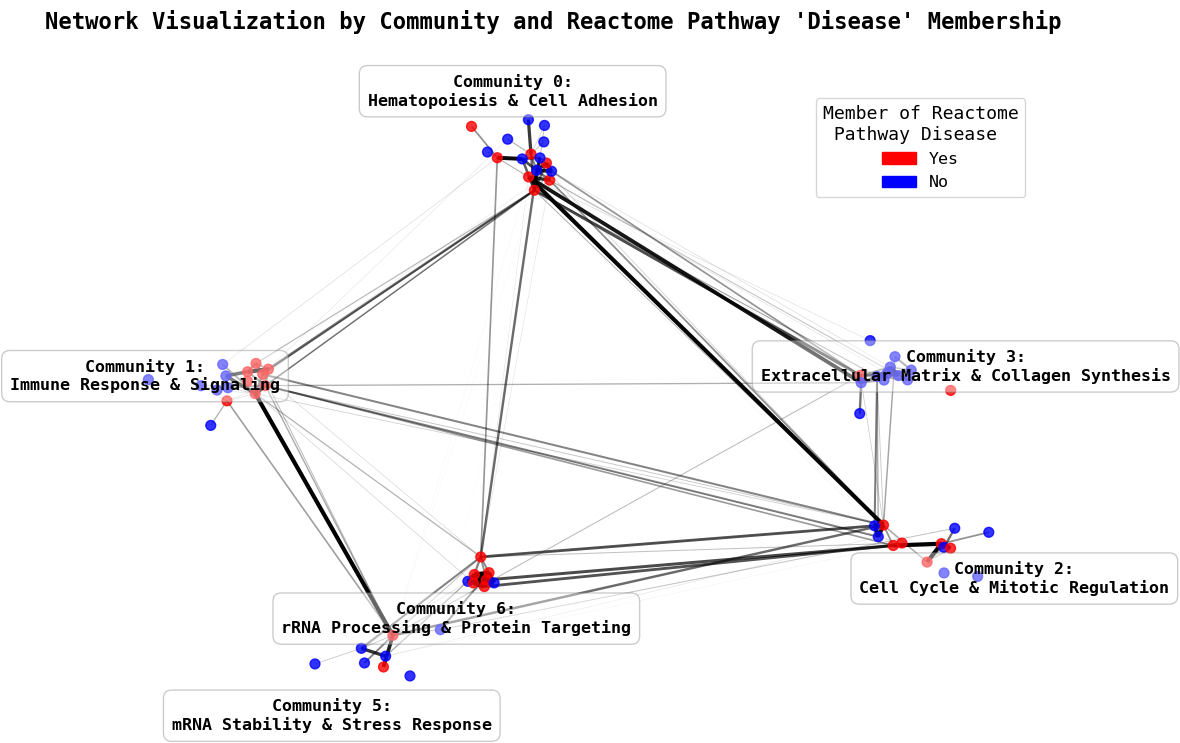

In [7]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

G = PPI.network.copy()

# Initial layout - spring layout for individual community clustering
pos = nx.spring_layout(G, seed=42)

# Step 1: Identify and remove nodes from community -1
nodes_to_remove = [node for node in G.nodes if G.nodes[node]['community'] == -1]
G.remove_nodes_from(nodes_to_remove)

# Calculate the centroid for each community
community_centroids = {}
for community in set(nx.get_node_attributes(G, 'community').values()):
    nodes_in_community = [node for node in G.nodes if G.nodes[node]['community'] == community]
    if nodes_in_community:  # Check if the community is not empty
        x_coords = [pos[node][0] for node in nodes_in_community]
        y_coords = [pos[node][1] for node in nodes_in_community]
        centroid = (np.mean(x_coords), np.mean(y_coords))
        community_centroids[community] = centroid

# Adjust node positions to enhance community clustering
# Define the scale for inter-community and intra-community adjustment
inter_community_scale = 10
intra_community_scale = 0.15

adjusted_pos = {}
for node in G.nodes:
    community = G.nodes[node]['community']
    original_pos = pos[node]
    centroid = community_centroids.get(community, (0, 0))  # Fallback to (0,0) if not found
    # Calculate adjusted position
    adjusted_x = centroid[0] + intra_community_scale * (original_pos[0] - centroid[0])
    adjusted_y = centroid[1] + intra_community_scale * (original_pos[1] - centroid[1])
    adjusted_pos[node] = (adjusted_x * inter_community_scale, adjusted_y * inter_community_scale)


# Extract weights
weights = [G[u][v]['weight'] for u,v in G.edges()]
# Normalize weights (optional, depending on your data)
max_weight = max(weights)
min_weight = min(weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]

# Calculate the figure center by averaging all adjusted node positions
all_x, all_y = zip(*adjusted_pos.values())
center_x, center_y = np.mean(all_x), np.mean(all_y)

# Visualization
plt.figure(figsize=(12, 8))
# Draw nodes, remembering the color coding for disease state
disease_colors = [G.nodes[n]['Disease'] for n in G.nodes]  # 0 or 1 indicating disease state
color_map = {0: 'blue', 1: 'red'}  # Mapping of disease state to color
nx.draw_networkx_nodes(G, adjusted_pos, node_color=[color_map[disease] for disease in disease_colors], node_size=50, alpha=0.8)

# Draw edges with width and alpha based on weight
for (u, v), lw, alpha in zip(G.edges(), normalized_weights, normalized_weights):
    nx.draw_networkx_edges(G, adjusted_pos, edgelist=[(u, v)], width=lw*3, alpha=alpha)  # Adjust multiplier and alpha offset as needed

# Adjusting label positions
for community, centroid in community_centroids.items():
    adjusted_centroid = (centroid[0] * inter_community_scale, centroid[1] * inter_community_scale)
    
    # Calculate the difference from the center
    diff_x = adjusted_centroid[0] - center_x
    diff_y = adjusted_centroid[1] - center_y
    
    # Calculate new label positions at 1.2 times the difference from the center
    label_x = center_x + 1.25 * diff_x
    label_y = center_y + 1.25 * diff_y
    
    plt.text(label_x, label_y, f'Community {community}:\n{community_labels[community]}', 
             horizontalalignment='center', verticalalignment='center', 
             fontsize=12, fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.4, edgecolor='grey', boxstyle='round,pad=0.5'))

# Adding a legend for the disease state
red_patch = mpatches.Patch(color='red', label='Yes')
blue_patch = mpatches.Patch(color='blue', label='No')
plt.legend(handles=[red_patch, blue_patch], title="Member of Reactome\n"
                                                  " Pathway Disease", title_fontsize='13', loc='upper right', fontsize='12')

# Add a title to the plot
plt.suptitle("Network Visualization by Community and Reactome Pathway 'Disease' Membership", fontsize=16, fontweight='bold')


plt.axis('off')
plt.show()

What we can see here, is that all of our more detaileld communities, somehow contribute to the significance of the general term 'Disease' when analyzing the gene list as one large input. This actually represents a prime example of how results that are related to a variety of underlying processes, can to a large extent contribute to unspecific top-level terms. While e.g. the genes found in community 2 do mainly contribute to terms related to Cell Cycle and mitotic regulation, they also partially contribute to the significance of the term 'Disease'. As the is true also for the other communities we find here, this more unspecific term gains more significance the more diverse biological processes are actually part of the results. This is why our community detection helped here to put more emphasize on the individual results hidden within this complex list of genes!